In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


In [3]:
# import spectroscopy data 
X = pd.read_csv('RamanSpectra.csv', header=None).to_numpy()            #Spectra
y = pd.read_csv('RamanConcentrations.csv', header=None).to_numpy()     #Concentrations
S = pd.read_csv('RamanShifts.csv', header=None).to_numpy()             #Raman Shifts
Species = ['Kyanite','Wollastonite','Olivine','Silica','Zircon'] # different insoluble GFCs for raman spec. 


In [4]:
# test train split: (Not required)
X_train, X_test, y_train, y_test = train_test_split(S, X[1, :], test_size = 0.2, random_state= 1)

In [5]:
# NN for interpolation
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler  # Import StandardScaler from scikit-learn

# Step 2: Prepare the dataset 
class CustomDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

# 'input_data' and 'output_data' into the neural net
output_data_np = signal.savgol_filter(X, window_length = 19, polyorder = 2, deriv = 1)  # spectral intensity (y axis) 
input_data_np = S   # wavelengths (x axis)

# Standard scaling for input data
input_scaler = StandardScaler()
input_data_np = input_scaler.fit_transform(input_data_np)

# Standard scaling for output data
output_scaler = StandardScaler()
output_data_np = output_scaler.fit_transform(output_data_np.reshape(-1, 1))

# convert to torch tensor
input_data = torch.tensor(input_data_np, dtype=torch.float32)
output_data = torch.tensor(output_data_np, dtype=torch.float32)

# Step 3: Create DataLoader
batch_size = 32
dataset = CustomDataset(input_data, output_data)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Step 4: Create the neural network architecture
class InterpolationModel(nn.Module):
    def __init__(self):
        super(InterpolationModel, self).__init__()
        self.fc1 = nn.Linear(1, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = InterpolationModel()

# Step 5: Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 6: Training loop
num_epochs = 100
for epoch in range(num_epochs):
    for inputs, targets in data_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {loss.item()}")

# Standard scaling for test input
test_input_np = input_scaler.transform(S)

# convert to tensor 
test_input = torch.tensor(test_input_np, dtype=torch.float32)

with torch.no_grad():
    predictions = model(test_input)
    
    
predictions = output_scaler.inverse_transform(predictions)
    
# 'predictions' now contains the predicted intensities
print(predictions)

Epoch [1/100] Loss: 0.01567748934030533
Epoch [2/100] Loss: 0.0006224384414963424
Epoch [3/100] Loss: 6.0313432186376303e-05
Epoch [4/100] Loss: 0.00823681615293026
Epoch [5/100] Loss: 0.03623887524008751
Epoch [6/100] Loss: 0.00040350283961743116
Epoch [7/100] Loss: 0.0001403852365911007
Epoch [8/100] Loss: 0.05293319746851921
Epoch [9/100] Loss: 5.545981548493728e-05
Epoch [10/100] Loss: 0.0003392147191334516
Epoch [11/100] Loss: 0.0013804684858769178
Epoch [12/100] Loss: 0.010023819282650948
Epoch [13/100] Loss: 7.550344435003353e-06
Epoch [14/100] Loss: 0.008304581046104431
Epoch [15/100] Loss: 0.009173063561320305
Epoch [16/100] Loss: 0.5249031186103821
Epoch [17/100] Loss: 0.001038005924783647
Epoch [18/100] Loss: 0.07061206549406052
Epoch [19/100] Loss: 0.034126877784729004
Epoch [20/100] Loss: 0.0008627325878478587
Epoch [21/100] Loss: 0.005316967144608498
Epoch [22/100] Loss: 5.44644717592746e-05
Epoch [23/100] Loss: 0.0018156690057367086
Epoch [24/100] Loss: 0.768802583217620

Text(0.5, 1.0, 'Raman Spectroscopy')

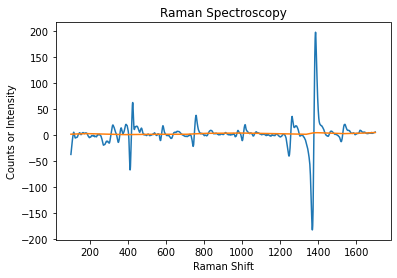

In [6]:
# plot of raman spectrum with SG filter
plt.plot(S, signal.savgol_filter(X[1, :], window_length = 19, polyorder = 2, deriv = 1))
plt.plot(S, predictions)
plt.xlabel("Raman Shift")
plt.ylabel("Counts or Intensity")
plt.title("Raman Spectroscopy")